In [1]:
from evo.core import metrics

In [83]:
from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

[DEBUG][2023-07-20 23:39:04,502][log.configure_logging():112]
System info:
Python 3.8.17
Linux-5.19.0-46-generic-x86_64-with-glibc2.17
slam@slam-TensorBook



In [150]:
import pandas as pd
import time

In [85]:
# Step 1: Read the CSV file
df = pd.read_csv("./logs/log.csv")

# Step 2: Select several columns by their names
selected_columns = ["TimeStamp", "PX", "PY", "PZ", "Q1", "Q2", "Q3", "Q4"]  # Replace with your desired column names
df = df[selected_columns]

# Step 3: Drop the header line (if needed)
# If the header line needs to be dropped, you can reset the index after skipping the first row.
# Uncomment the next line if you want to remove the header line.
#invalid_rows = len(df[df["PX"]==0.0])
invalid_rows = sum(1-(df["PX"][:100]==0.0))
invalid_rows
df = df.iloc[invalid_rows:-10].reset_index(drop=True)

# Step 4: Save the DataFrame as a text (TXT) file
df.to_csv("./logs/trajectory.txt", sep=' ', index=False, header=False)  # You can change the separator as needed

In [86]:
df

,TimeStamp,PX,PY,PZ,Q1,Q2,Q3,Q4
0,1.198455e+06,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000
1,1.198455e+06,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000
2,1.198455e+06,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000
3,1.198455e+06,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000
4,1.198455e+06,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000
...,...,...,...,...,...,...,...,...
1293,1.198498e+06,0.089255,0.146800,0.091474,-0.104249,0.339067,0.695176,0.625216
1294,1.198498e+06,0.094938,0.143993,0.092717,-0.107931,0.339891,0.695693,0.623567
1295,1.198498e+06,0.096945,0.143024,0.092799,-0.107335,0.341839,0.695531,0.622785
1296,1.198498e+06,0.089960,0.141021,0.092606,-0.103626,0.344837,0.694791,0.622587


In [87]:
1-(df["PX"][:100]==0.0)

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: PX, Length: 100, dtype: int64

In [88]:
invalid_rows = sum(1-(df["PX"][:100]==0.0))
invalid_rows

0

In [89]:
from evo.tools import file_interface

In [90]:
ref_source_file = "./datasets/A3/groundtruth/data.csv"

df = pd.read_csv(ref_source_file)
df.to_csv("./logs/trajectory_gt.txt", sep=' ', index=False, header=False)

In [91]:

ref_file = "./logs/trajectory_gt.txt"
est_file = "./logs/trajectory.txt"

traj_est = file_interface.read_tum_trajectory_file(est_file)
traj_ref = file_interface.read_tum_trajectory_file(ref_file)


[DEBUG][2023-07-20 23:39:09,172][file_interface.read_tum_trajectory_file():117]
Loaded 1298 stamps and poses from: ./logs/trajectory.txt
[DEBUG][2023-07-20 23:39:09,284][file_interface.read_tum_trajectory_file():117]
Loaded 18437 stamps and poses from: ./logs/trajectory_gt.txt


In [92]:
from evo.core import sync

max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)

[DEBUG][2023-07-20 23:39:09,389][sync.associate_trajectories():110]
Found 1298 of max. 1298 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


In [93]:
import copy

traj_est_aligned = copy.deepcopy(traj_est)
traj_est_aligned.align(traj_ref, correct_scale=False, correct_only_scale=False)

[DEBUG][2023-07-20 23:39:09,635][trajectory.align():202]
Aligning using Umeyama's method...
[DEBUG][2023-07-20 23:39:09,640][trajectory.align():214]
Rotation of alignment:
[[ 0.29044687  0.36408719  0.88491872]
 [ 0.90305962  0.20151191 -0.37931025]
 [-0.31642366  0.90930384 -0.27026393]]
Translation of alignment:
[-0.15759063 -0.14931742 -0.45037942]
[DEBUG][2023-07-20 23:39:09,640][trajectory.align():216]
Scale correction: 1.0


(array([[ 0.29044687,  0.36408719,  0.88491872],
        [ 0.90305962,  0.20151191, -0.37931025],
        [-0.31642366,  0.90930384, -0.27026393]]),
 array([-0.15759063, -0.14931742, -0.45037942]),
 1.0)

In [199]:
pose_relation = metrics.PoseRelation.rotation_angle_deg

# normal mode
delta = 2
delta_unit = metrics.Unit.meters


#delta = 90
#delta_unit = metrics.Unit.frames

# all pairs mode
all_pairs = True #False # True  # activate

In [200]:
data = (traj_ref, traj_est)

In [201]:
%%time

rpe_metric = metrics.RPE(pose_relation=pose_relation.translation_part, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
rpe_metric.process_data(data)

[DEBUG][2023-07-21 08:32:56,289][metrics.id_pairs_from_delta():449]
Found 1067 pairs with delta 2 (m) among 1298 poses using all pairs.
[DEBUG][2023-07-21 08:32:56,301][metrics.process_data():294]
Compared 1067 relative pose pairs, delta = 2 (m) with all pairs.
[DEBUG][2023-07-21 08:32:56,301][metrics.process_data():300]
Calculating RPE for translation part pose relation...
CPU times: user 22.5 ms, sys: 502 µs, total: 23 ms
Wall time: 22.9 ms


In [202]:
error = rpe_metric.error
error

[0.19836821066919064,
 0.19912224700041342,
 0.1985800391323491,
 0.19831018128331102,
 0.19792809011761012,
 0.1980870121563418,
 0.1989809073286964,
 0.19883187145298875,
 0.19868528957826428,
 0.19867188462157673,
 0.1983186305908374,
 0.19935384132963407,
 0.19956267714148043,
 0.19907342475814008,
 0.1997723547812211,
 0.19948777715399083,
 0.19913817307239445,
 0.20041863110390684,
 0.20030818122333602,
 0.20022292392984264,
 0.20004675384056286,
 0.19958660678144022,
 0.2004364781099076,
 0.20040146291971714,
 0.20051239314416874,
 0.20082745786662923,
 0.2006592767362244,
 0.20161969184704673,
 0.20162298834693626,
 0.20129180632432603,
 0.20215631068149384,
 0.2022218397880989,
 0.2025495898734647,
 0.20302605656228398,
 0.20255295142357324,
 0.20322944602219148,
 0.20339938173924108,
 0.2029218520919826,
 0.2032028408442034,
 0.20330339576617634,
 0.203434338019047,
 0.20429462243357185,
 0.2042493464716451,
 0.2039099971896764,
 0.20424834201410982,
 0.2044552014943508,
 0.2

In [203]:
len(error)

1067

<IPython.core.display.Javascript object>


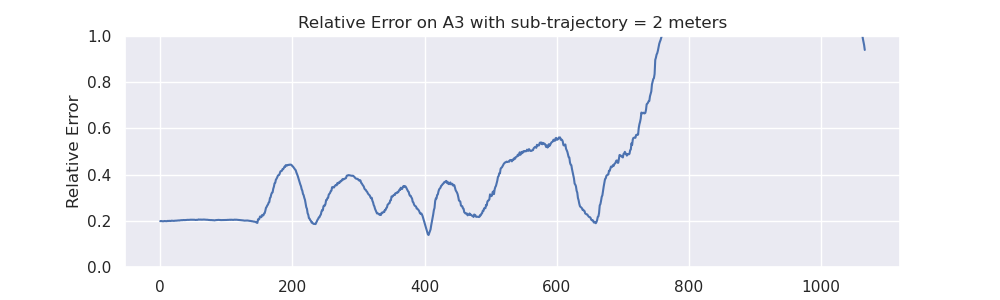

Text(0.5, 1.0, 'Relative Error on A3 with sub-trajectory = 2 meters')

In [204]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,3])
# Plot the line
plt.plot(error)
plt.ylim(0,1)
# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Relative Error')
plt.title('Relative Error on A3 with sub-trajectory = {} meters'.format(delta))

# Display the plot